In [1]:
import numpy as np
import os
from skimage.measure import block_reduce
from scipy.misc import imread
import cPickle as pkl
import scipy.signal
import numpy.fft as fft
import sys
import optparse
from libtiff import TIFF
from PIL import Image
import re
import itertools
from scipy import ndimage
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# imdir = '/media/juliana/MAC/data/JR009/20150625_block2/20150625_JR009_500um_0080Hz_blueLED/V-Left_0'
imdir = '/media/juliana/MAC/data/JR009/20150625_block2/20150625_JR009_500um_0080Hz_red2/V-Left_00'

In [3]:
im_format = '.png'
target_freq = 0.08
reduce_factor = (2, 2)
reduceit=1
sampling_rate = 60.0
cycle_dur = 1./target_freq
binspread = 0


In [4]:
basepath = os.path.split(os.path.split(imdir)[0])[0]
session = os.path.split(os.path.split(imdir)[0])[1]
cond = os.path.split(imdir)[1]

print "basepath: ", basepath
print "session: ", session
print "cond: ", cond

basepath:  /media/juliana/MAC/data/JR009/20150625_block2
session:  20150625_JR009_500um_0080Hz_red2
cond:  V-Left_00


In [10]:
files = os.listdir(imdir)
print len(files)
files = sorted([f for f in files if os.path.splitext(f)[1] == str(im_format)])
print len(files)

tiff = TIFF.open(os.path.join(imdir, files[0]), mode='r')
sample = tiff.read_image().astype('float')
print "sample type: %s, range: %s" % (sample.dtype, str([sample.max(), sample.min()]))
print "sample shape: %s" % str(sample.shape)
tiff.close()

14979
14979
sample type: float64, range: [3872.0, 1867.0]
sample shape: (246, 328)


In [6]:
# FIND CYCLE STARTS:
# positions = [re.findall("\[([^[\]]*)\]", f) for f in files]
# plist = list(itertools.chain.from_iterable(positions))
# positions = [map(float, i.split(',')) for i in plist]
# if 'H-Up' in cond:
#     find_cycs = list(itertools.chain.from_iterable(
#         np.where(np.diff([p[1] for p in positions]) < 0)))
# if 'H-Down' in cond:
#     find_cycs = list(itertools.chain.from_iterable(
#         np.where(np.diff([p[1] for p in positions]) > 0)))
# if 'V-Left' in cond:
#     find_cycs = list(itertools.chain.from_iterable(
#         np.where(np.diff([p[0] for p in positions]) < 0)))
# if 'V-Right' in cond:
#     find_cycs = list(itertools.chain.from_iterable(
#         np.where(np.diff([p[0] for p in positions]) > 0)))
# idxs = [i + 1 for i in find_cycs]
# idxs.append(0)
# idxs.append(len(positions))
# idxs = sorted(idxs)
# nframes_per_cycle = [idxs[i] - idxs[i - 1] for i in range(1, len(idxs))]

In [18]:
sample = block_reduce(sample, reduce_factor, func=np.mean)
print sample.shape

(123, 164)


In [19]:
# READ IN THE FRAMES:
stack = np.empty((sample.shape[0], sample.shape[1], len(files)))
print len(files)

print('copying files')

for i, f in enumerate(files):

#     if i % 100 == 0:
#         print('%d images processed...' % i)
    tiff = TIFF.open(os.path.join(imdir, f), mode='r')
    im = tiff.read_image().astype('float')
    tiff.close()

    if reduceit:
        if i==1:
            print "reducing..."
        im_reduced = block_reduce(im, reduce_factor, func=np.mean)
        # ndimage.gaussian_filter(im_reduced, sigma=gsigma)
        stack[:, :, i] = im_reduced
    else:
        stack[:, :, i] = im

print "done loading stack"

14979
copying files
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing...
reducing

(123, 164)


(123, 164, 14979)

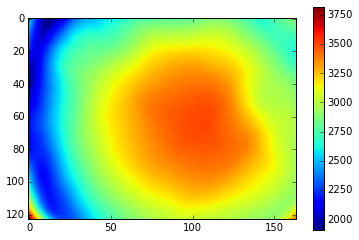

In [30]:
# SUBTRACT "average" frame from each frame?

average_frame = np.mean(stack, axis=2)
plt.imshow(average_frame)
plt.colorbar()
print average_frame.shape
stack.shape

In [11]:
# Mean-subtracted frames:

# for i, f in enumerate(files):
#     stack[:,:,i] -= average_frame


In [22]:
# SET FFT PARAMETERS:

freqs = fft.fftfreq(len(stack[0, 0, :]), 1 / sampling_rate) # When set fps to 60 vs 120 -- target_bin should be 2x higher for 120, but freq correct (looks for closest matching target_bin )
binwidth = freqs[1] - freqs[0]

target_bin_calc = int(target_freq / binwidth)
target_bin = np.where(
    freqs == min(freqs, key=lambda x: abs(float(x) - target_freq)))[0][0]

print "TARGET: ", target_bin, freqs[target_bin]
print "target bin calculate: ", target_bin_calc, freqs[target_bin_calc]

freqs[target_bin-1], freqs[target_bin], freqs[target_bin+1]
# print "FREQS: ", freqs

# freqs_shift = fft.fftshift(freqs)
# target_bin_shift = np.where(freqs_shift == min(
#     freqs_shift, key=lambda x: abs(float(x) - target_freq)))[0][0]
# print "TARGET-shift: ", target_bin_shift, freqs_shift[target_bin_shift]
# print "FREQS-shift: ", freqs_shift

# window = sampling_rate * cycle_dur * 2

TARGET:  20 0.0801121570198
target bin calculate:  19 0.0761065491688


(0.076106549168836371, 0.080112157019827768, 0.084117764870819151)

In [23]:
# pre-allocate:

# FFT:
# mag_map = np.empty(sample.shape)
# phase_map = np.empty(sample.shape)

# ft_real = np.empty(sample.shape)
# ft_imag = np.empty(sample.shape)

ft = np.empty(sample.shape)
ft = ft + 0j

# ft_real_shift = np.empty(sample.shape)
# ft_imag_shift = np.empty(sample.shape)

# dynrange = np.empty(sample.shape)

dlist = []

i = 0
for x in range(sample.shape[0]):
    for y in range(sample.shape[1]):

        # THIS IS BASICALLY MOVING AVG WINDOW...
        pix = scipy.signal.detrend(stack[x, y, :], type='constant')

#         dynrange[x, y] = np.log2(pix.max() - pix.min())

        curr_ft = fft.fft(pix)  # fft.fft(pix) / len(pix)])

#         mag = np.abs(curr_ft)
#         # mag_max = np.where(mag == mag.max())
#         # mag_min = np.where(mag == mag.min())

#         ft_real[x, y] = curr_ft[target_bin].real
#         ft_imag[x, y] = curr_ft[target_bin].imag

        ft[x, y] = curr_ft[target_bin]

#         mag_map[x, y] = mag[target_bin]

        dlist.append((x, y, curr_ft))

        i += 1
        
DF = pd.DataFrame.from_records(dlist)

In [28]:
# sessionpath = os.path.split(imdir)[0]
sessionpath = '/media/juliana/IMDATA/widefield/JR009/20150625_block2/20150625_JR009_500um_0080Hz_red2'
outdir = os.path.join(sessionpath, 'structs')

fext = 'Full_fft_%s_%s.pkl' % (cond, str(reduce_factor))
fname = os.path.join(outdir, fext)
print fname
DF.to_pickle(fname)  # where to save it, usually as a .pkl
# df = pd.read_pickle(file_name) # to load

# DF

/media/juliana/IMDATA/widefield/JR009/20150625_block2/20150625_JR009_500um_0080Hz_red2/structs/Full_fft_V-Left_00_(2, 2).pkl


In [ ]:
DF[2][100]

In [122]:
nineteen = [np.angle(i[20])for i in DF[2]]
# nineteen = [(np.angle(i[19])+np.angle(i[20])+np.angle(i[21]))/3. for i in DF[2]]

(123, 164)


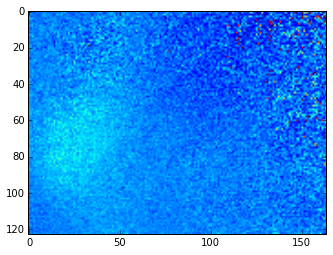

In [123]:
pmap = np.array(nineteen).reshape(sample.shape)
print pmap.shape
plt.imshow(pmap)

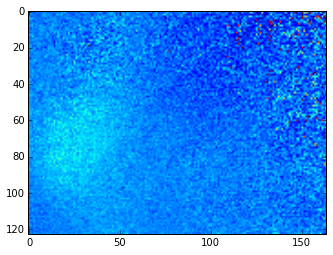

In [124]:
plt.imshow(np.angle(ft))